In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

from pyPSFstack.pupils.sources import DipoleInterfaceSource
from pyPSFstack.pupils.windows import SEO, Qplate
from pyPSFstack.pupils.aberrations import UnitaryAberrations
from pyPSFstack.core import PSFStack
from pyPSFstack.functions import trim_stack
from pyPSFstack.diversities.pola_diversities import PDiversity_QWP, \
    PDiversity_LP, PDiversity_Compound
from pyPSFstack.diversities.pupil_diversities import ZDiversity
from pyPSFstack.blurring import ExactBlurring

from pyPSFstack_torch.psf_modules import torchPSFStack
from pyPSFstack_torch.pupils.sources import torchDipoleInterfaceSource
from pyPSFstack_torch.pupils.windows import torchSEO
from pyPSFstack_torch.pupils.aberrations import torchUnitaryAberrations
from pyPSFstack_torch.diversities.pupil_diversities import torchZDiversity
from pyPSFstack_torch.diversities.pola_diversities import torchPDiversity_QWP, \
    torchPDiversity_LP, torchPDiversity_Compound
from pyPSFstack_torch.cost_functions import loss_loglikelihood, loss_sumsquared
from pyPSFstack_torch.functions import get_pupils_param_dict, get_normNbck, colorize


# torchPSFstack: Example of use 

## 1. Simulate experimental data using pyPSFstack

### 1.1. Parameter definition

In [2]:
# Define number of points use for the computation 
N_pts = 128
# Experimental parameters
numerical_aperture = 1.49
magnification = 100
ni = 1.33
nf = 1.518
cam_pixel_size = 6500
radius = 10
wavelength = 525
dipole_orientation = [0,0,0] # this means incoherent
# Define positions of defocus
zi = -500; zf = 500; z_step = 100
z_list = np.arange(zi,zf+z_step,z_step)
# Define rotation angles of polarization analyzer
angle_i = 0; angle_f = np.pi/2; angle_step = np.pi/8
angle_list=np.arange(angle_i,angle_f,angle_step)

Put all necessary parameters in dicts

In [31]:
params = {}
params['pupil'] = {}
params['pupil']['aperture_size'] = numerical_aperture / nf
params['pupil']['computation_size'] = wavelength*magnification/(cam_pixel_size*nf)
params['pupil']['N_pts'] = N_pts

params['source'] = {}
params['source']['ni'] = ni
params['source']['nf'] = nf
params['source']['delta'] = radius/wavelength

params['window'] = {}
params['window']['c'] = 1.25*np.pi#np.pi#1.24*np.pi

params['zdiversity'] = {}
params['zdiversity']['z_list'] = z_list / wavelength
params['zdiversity']['nf'] = nf

params['blurring'] = {}
params['blurring']['ni'] = ni
params['blurring']['nf'] = nf
params['blurring']['radius'] = radius/wavelength
params['blurring']['diff_del_list'] = np.linspace(-radius/wavelength,
    radius/wavelength,8)[1:-1] 

### 1.2. Instantiate all necessary class elements

In [32]:
# The source and window define th epupil sequence
src = DipoleInterfaceSource(**params['pupil'],**params['source'])
wdw = SEO(**params['pupil'],**params['window'])
pupil_sequence = [src, wdw]
# Then the diversities
zdiv = ZDiversity(**params['zdiversity'], **params['pupil'])
# The polarization diversity is taken as a rotating QWP followed 
# by a wollastan which splits into horizontal and vertical polarized
# light 
qwp = PDiversity_QWP(angle_list)
wollaston = PDiversity_LP([0, np.pi/2])
pdiv = PDiversity_Compound([qwp, wollaston])
# Finally we define the blurring as the exact model to try
# to mimic the experimental result
blurring = ExactBlurring(**params['blurring'],**params['pupil'])

psfs = PSFStack(pupil_sequence, zdiversity=zdiv, pdiversity=pdiv, blurring=blurring)


### 1.3. Compute the PSF stack

We compute the stack for an incoherent dipole

In [33]:
psfs.compute_psf_stack(orientation=[0,0,0])

Then we add the background illumination and noise

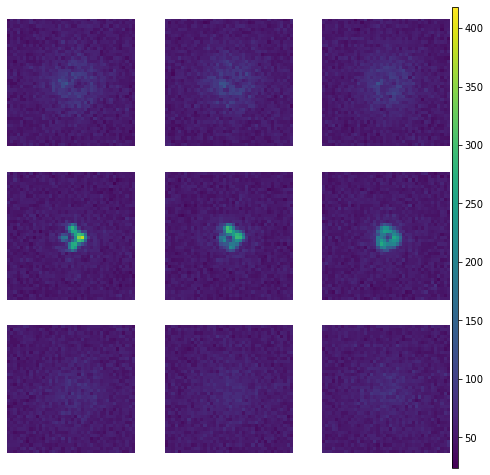

In [34]:
data_stack = psfs.model_experimental_stack(bckgd_photons=50,N_photons=10000,N_pts=40,noise=True)
v_max = np.max(data_stack)
v_min = np.min(data_stack)

zdiv_mid_ind = int((zf-zi)/z_step//2)
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ind in range(3):
    axs[0,ind].imshow(data_stack[...,0,ind],vmin=v_min,vmax=v_max)
    im = axs[1,ind].imshow(data_stack[...,zdiv_mid_ind,ind],vmin=v_min,vmax=v_max)
    axs[2,ind].imshow(data_stack[...,-1,ind],vmin=v_min,vmax=v_max)
for ax in axs.ravel():
    ax.set_axis_off()

cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

## 2. Birefringent pupil retrieval

### 2.1. Model definition

First we instantiate all necessary class elements

In [35]:
params['aberrations'] = {}
params['aberrations']['jmax_list'] = [15]*4+[15]

tsrc = torchDipoleInterfaceSource(**params['pupil'],**params['source'])
twdw = torchUnitaryAberrations(**params['pupil'], **params['aberrations'])
tpupil_sequence = [tsrc, twdw]
tzdiv = torchZDiversity(**params['zdiversity'], **params['pupil'])
tpdiv = torchPDiversity_Compound([torchPDiversity_QWP(angle_list), 
    torchPDiversity_LP([0, np.pi/2])])

model_retrieved = torchPSFStack(
                 data_stack.shape[0],
                 tpupil_sequence,
                 zdiversity=tzdiv,
                 pdiversity=tpdiv
                 )

Then, we use the model data to estimate the scaling factor and background illumination

In [36]:
data_norm, data_bck = get_normNbck(data_stack)
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()
model_retrieved.set_scale_factor(data_norm/torch.sum(first_est))
model_retrieved.set_pb_bck(data_bck, opt_b=True) # optimize background
with torch.no_grad():
    model_retrieved.eval()
    first_est = model_retrieved()

### 2.2. Launch optimization

Set learning rate, and number of iterations

In [37]:
lr = 1e-2
n_epochs = 200

loss_fn = loss_loglikelihood#nn.MSELoss(reduction='mean')#

optimizer = torch.optim.Adam(
    model_retrieved.parameters(), 
    lr=lr
)
data = torch.from_numpy(data_stack).type(torch.float)

Run optimization

100%|██████████| 200/200 [00:17<00:00, 11.27it/s]


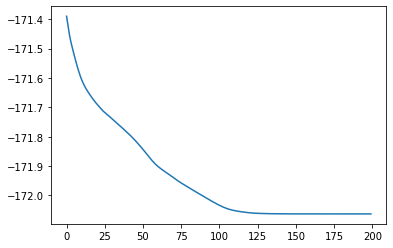

In [38]:
loss_evol =[]
for epoch in tqdm(range(n_epochs)):
    
    model_retrieved.train()
    yhat = model_retrieved()
    
    loss = loss_fn(yhat, data)
    loss_evol += [loss.item()]
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

plt.plot(loss_evol)

## 3. Comparrison

### 3.1. PSFstack

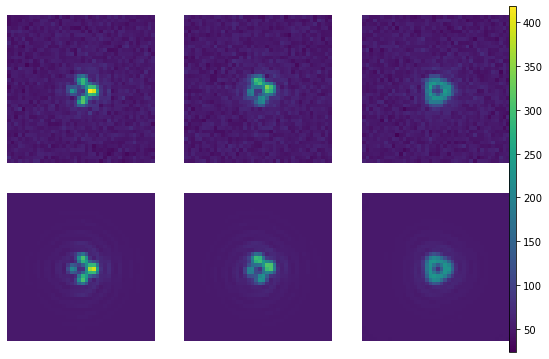

In [39]:
zdiv_mid_ind = int((zf-zi)/z_step//2) # mid point should be in focus psf
ret_stack = yhat.detach()
fig, ax = plt.subplots(2,3,figsize=(9,6))
for ind in range(3):
    im = ax[0,ind].imshow(data_stack[...,zdiv_mid_ind-1,ind],vmin=v_min,vmax=v_max)
    ax[0,ind].set_axis_off()
    ax[1,ind].imshow(ret_stack[...,zdiv_mid_ind-1,ind],vmin=v_min,vmax=v_max)
    ax[1,ind].set_axis_off()
cb_ax = fig.add_axes([0.9,0.1,0.01,0.8])
fig.colorbar(im, cax=cb_ax)

### 3.2 Birefringent pupil

We retrieve the parameters of the aberrations mask found during the optimization and instantiate the corresponding class element of ``pyPSFstack`` for easy handling and plotting

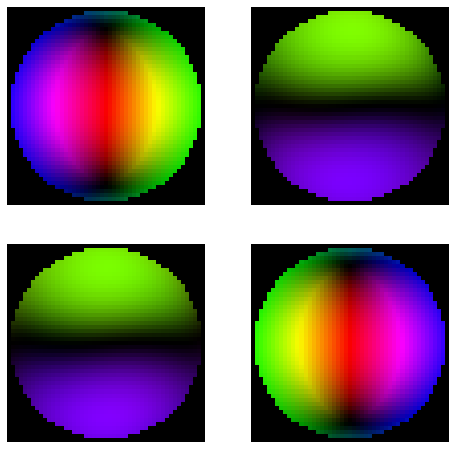

In [40]:
ret_pupil_params = get_pupils_param_dict(model_retrieved)
abe = UnitaryAberrations(**params['pupil'], 
     **ret_pupil_params['pupil1'])
abe.plot_pupil_field()

Compare to the defined mask

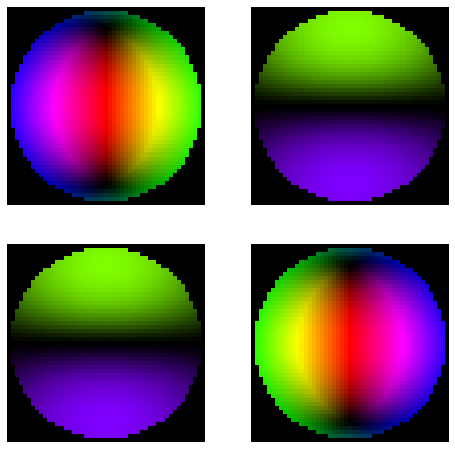

In [24]:
wdw.plot_pupil_field()